# Facial expression classification

### Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### MIT License

Copyright (c) 2017 François Chollet                                                                                         

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.


# Transfer Learning Using Pretrained ConvNets
In this workshop you will load data with tf.data in TensorFlow 2.0 for image classification of emotions by using transfer learning from a pre-trained MobileNetV2 network. The work is adapted from the following [tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/images/transfer_learning.ipynb). 


Concepts
------
* **Pre-trained model**: A saved neural network that was previously trained on a large dataset. The parameters of the model are saved for you to serve predictions as it is, or use **transfer learning** to customize this model to a given task.
* **Transfer learning**: Taking the model's parameters and train on a different dataset. Typically this also involves modifying part of the model structure.
* **Embeddings**: Features representing the images. The pre-trained model transforms images into a lower dimensional vector (embeddings) which we will use for the classification task in transfer learning. 

The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps (i.e. embeddings) without having to start from scratch training a large model on a large dataset. You then build on top of the pre-trained model to classify the embeddings to categories specific to your own dataset (e.g. ASUS vs ACER vs Dell laptops).

In this notebook, you will attempt transfer learning in 2 stages:

1. **Feature Extraction + classification**: Extract the embeddings learned by [MobileNetV2](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html) pre-trained on [ImageNet](http://www.image-net.org/). You simply add a new classifier, which will be trained from scratch, on top of the pre-trained model so that you can repurpose the model for our dataset.

  You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained. For this workshop, we will be learning emotion classes with this [dataset](https://www.kaggle.com/aspiring1/fer2013-images).

2. **Fine-Tuning**: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the machine learning workflow:

1. Examine and understand the data
2. Build an input pipeline
3. Compose our model
  * Load in our pretrained base model (and pretrained weights)
  * Stack our classification layers on top
4. Train our model
5. Evaluate model
6. Repeat 4 and 5, training more layers


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

keras = tf.keras

In [3]:
!pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.0.0b1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python2.7/dist-packages
Requires: keras-applications, mock, grpcio, enum34, google-pasta, termcolor, numpy, tb-nightly, wheel, astor, six, tf-estimator-nightly, gast, keras-preprocessing, protobuf, wrapt, absl-py, backports.weakref


### Getting our data
The Kaggle [dataset](https://www.kaggle.com/aspiring1/fer2013-images) which we will be working with consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. 

This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project.

In [4]:
%%bash
unzip -o fer2013-images.zip
sudo tar -zxf images.tar.gz
ls

Archive:  fer2013-images.zip
  inflating: images.tar.gz           
assets
emotion.h5
EmotionModel_backup.ipynb
EmotionModel.ipynb
emotion.tflite
fer2013-images.zip
images_fer2013
images.tar.gz
MobileNetV2_transfer
RockPaperScissorsModel.ipynb
sample_images.zip
saved_model.pb
tensorflow_datasets
tutorials
variables


#### Creating a list paths to images
`pathlib.Path` is used to access the folders.

In [5]:
import pathlib
data_root_orig = 'images_fer2013'
data_root = pathlib.Path(data_root_orig)
print(data_root)

images_fer2013


The dataset is arranged into 3 folders, Training, PublicTest, and PrivateTest but we will be doing our own train, validation, test dataset split.

In [6]:
for item in data_root.iterdir():
  print(item)

images_fer2013/PublicTest
images_fer2013/Training
images_fer2013/PrivateTest


`pathlib.Path.glob` helps us to read in every jpeg image in all subfolders. We will read in all the images and shuffle them.

In [7]:
import random

print('%d images' % len(list(data_root.glob('**/*.jpg'))))
all_image_paths = list(data_root.glob('**/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

35887 images


35887

Put all these into a function to return a list of image paths.

In [8]:
def get_image_paths(root, pattern='*/*'):
    data_root = pathlib.Path(root)
    paths = list(data_root.glob(pattern))
    paths = [str(path) for path in paths]
    random.shuffle(paths)
    
    return paths

Each of the subfolders are named after an emotion (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral). The task is to categorise the images by these labels.

In [9]:
all_image_paths = get_image_paths(data_root_orig, '**/*.jpg')
print(all_image_paths[:10])

35887
['images_fer2013/Training/Happy/2063.jpg', 'images_fer2013/Training/Fear/26418.jpg', 'images_fer2013/Training/Fear/9261.jpg', 'images_fer2013/Training/Angry/16287.jpg', 'images_fer2013/Training/Angry/9351.jpg', 'images_fer2013/PublicTest/Surprise/32165.jpg', 'images_fer2013/Training/Angry/14248.jpg', 'images_fer2013/PrivateTest/Fear/34236.jpg', 'images_fer2013/Training/Fear/8187.jpg', 'images_fer2013/Training/Sad/20964.jpg']


images_fer2013/Training/Sad/11359.jpg


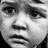

images_fer2013/Training/Sad/22117.jpg


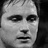

images_fer2013/PublicTest/Fear/31903.jpg


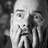

In [10]:
import IPython.display as display
for n in range(3):
  image_path = random.choice(all_image_paths)
  print(image_path)
  display.display(display.Image(image_path))

#### Creating a list of labels the images
Now we also need a label for every image. We get the image labels again using `pathlib.Path.glob` and find the set of emotions.

In [11]:
label_names = [item.name for item in data_root.glob('*/*/') if item.is_dir()]
label_names = sorted(list(set(label_names)))
label_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

We will create indices for the labels.

In [12]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

And map each image in `all_image_paths` into labels `all_image_labels`.

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 2, 2, 0, 0, 6, 0, 2, 2, 5]


#### Load and formatting images

In [14]:
img_path = all_image_paths[0]
img_path

'images_fer2013/Training/Happy/2063.jpg'

We will be using `tf.io.read_file` to read in raw data:

In [ ]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

Decode the raw data to an image tensor:

In [16]:
img_tensor = tf.image.decode_image(img_raw, channels=3)

print(img_tensor.shape)
print(img_tensor.dtype)

(48, 48, 3)
<dtype: 'uint8'>


Resizing the image for the model:

In [17]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.040625
0.9990196


Wrap up the above preprocessing into functions for use later:

In [18]:
IMG_SIZE = 160 # All images will be resized to 160x160

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image /= 255.0  # normalize to [0,1] range
  #image = (image/127.5) - 1

  return image

In [19]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

images_fer2013/Training/Fear/26418.jpg 2



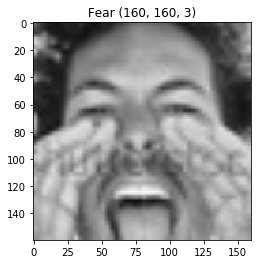

In [20]:
image_path = all_image_paths[1]
label = all_image_labels[1]
print(image_path, label)
plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title()+' '+str(load_and_preprocess_image(image_path).shape))
print()

`tf.data.Dataset.from_tensor_slices` will be used to unpack the (path, label) tuples. `tf.data.Dataset.map` then maps them into the preprocessed images and labels. The functions also take care of splitting the train, validation, and test datasets.

In [21]:
SPLIT_WEIGHTS = (0.8, 0.1, 0.1)

train_size = int(SPLIT_WEIGHTS[0] * image_count)
val_size = int(SPLIT_WEIGHTS[1] * image_count)
test_size = int(SPLIT_WEIGHTS[2] * image_count)

In [22]:
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def split_load_and_preprocess_from_path_label(paths, labels, size, s=(0.7, 0.15, 0.15)):
    train_size = int(s[0] * size)
    val_size = int(s[1] * size)
    test_size = int(s[2] * size)
    
    
    train_ds = tf.data.Dataset.from_tensor_slices((paths[:train_size], \
                                                   labels[:train_size]))
    val_ds = tf.data.Dataset.from_tensor_slices((paths[train_size:train_size+val_size], \
                                                 labels[train_size:train_size+val_size]))
    test_ds = tf.data.Dataset.from_tensor_slices((paths[-test_size:], \
                                                  labels[-test_size:]))

    train_image_label_ds = train_ds.map(load_and_preprocess_from_path_label)
    val_image_label_ds = val_ds.map(load_and_preprocess_from_path_label)
    test_image_label_ds = test_ds.map(load_and_preprocess_from_path_label)

    return train_image_label_ds, val_image_label_ds, test_image_label_ds

In [23]:
train, validation, test = split_load_and_preprocess_from_path_label(s=SPLIT_WEIGHTS, \
                                                                    paths=all_image_paths, \
                                                                    labels=all_image_labels, \
                                                                    size=image_count)
print(train, validation, test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int32)> <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int32)> <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int32)>


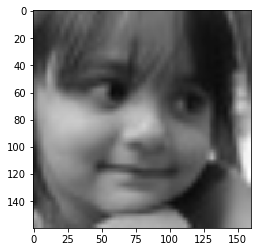

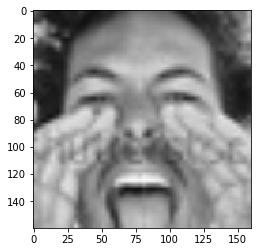

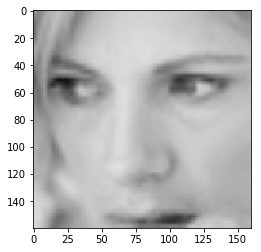

In [24]:
for image, label in train.take(3):
  plt.figure()
  plt.imshow(image)

#### Batching and shuffling
We want to the training dataset to be batched and well shuffled. This can be done again using tf.data api.

In [25]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [26]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [27]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## Creating the model
We will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like `jackfruit` and `syringe`. A model trained on these images should be a good basis to tell apart different entities like cats and dogs if that is our task for transfer learning. Emotions are probably subtler and hence we should expect it to be harder for the model to learn. Especially since we only have 48 x 48 pixel greyscale images.

First, we need to pick which layer of MobileNet V2 we will use for extracting the **embeddings**. Obviously, the very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, we will follow the common practice of using the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck features retain much generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for extracting the **embeddings**.

#### Loading the base model with pre-trained weights from imagenet

In [28]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

The base model without the last classification layer converts each 160x160x3 image to a 5x5x1280 block of features. Lets see what it does to the example batch of images:

In [29]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### Extracting the embeddings
We will freeze the base model created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

It is important to freeze before compiling and training the model. By freezing (or setting layer.trainable = False), we prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [30]:
base_model.trainable = False

In [31]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Add layers on top for classification
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image.

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into scores for 7 possible classes. We will use a `softmax` activation to convert the scores for each class into probabilities.

In [33]:
prediction_layer = keras.layers.Dense(7, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


Now stack the frozen base model that generates the embeddings together with these two layers using a `tf.keras.Sequential` model to create a classifier on top:

In [34]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### Compile the model
The model must be compiled before running. We will use `tf.keras.optimizers.RMSprop` for optimisation. Since there are 7 classes and our output labels are integers, we will use `sparse_categorical_crossentropy` as our loss.

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 8967 (1280 x 7 + 7) trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [37]:
len(model.trainable_variables)

2

#### Training the model
We will train for 10 epochs. Do not worry if the accuracy is low. As mentioned, MobileNet V2 is probably not trained to recognise the subtilities of human emotions. Also, our images are of low resolution and with 7 classes, we only have a few hundred images for our model to learn from. The main advantage of MobileNet V2 is really that it is lightweight and suitable for deploying in mobile devices, providing your devices with fast inferences.

In [38]:
num_train = int(SPLIT_WEIGHTS[0] * image_count)
num_val = int(SPLIT_WEIGHTS[1] * image_count)
num_test = int(SPLIT_WEIGHTS[2] * image_count)
print(num_train)
print(num_val)
print(num_test)

In [39]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 168ms/step - loss: 2.8125 - accuracy: 0.1203


In [40]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.81
initial accuracy: 0.12


In [41]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10


W0712 11:13:16.691975 140183753598720 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


898/898 [==============================] - 88s 98ms/step - loss: 1.8281 - accuracy: 0.2729 - val_loss: 2.3995 - val_accuracy: 0.2057
Epoch 2/10
898/898 [==============================] - 85s 95ms/step - loss: 1.6406 - accuracy: 0.3604 - val_loss: 2.3135 - val_accuracy: 0.2213
Epoch 3/10
898/898 [==============================] - 85s 94ms/step - loss: 1.5702 - accuracy: 0.3922 - val_loss: 2.2316 - val_accuracy: 0.2366
Epoch 4/10
898/898 [==============================] - 85s 95ms/step - loss: 1.5292 - accuracy: 0.4134 - val_loss: 2.1667 - val_accuracy: 0.2455
Epoch 5/10
898/898 [==============================] - 85s 95ms/step - loss: 1.5011 - accuracy: 0.4250 - val_loss: 2.1177 - val_accuracy: 0.2514
Epoch 6/10
898/898 [==============================] - 84s 94ms/step - loss: 1.4801 - accuracy: 0.4327 - val_loss: 2.0811 - val_accuracy: 0.2611
Epoch 7/10
898/898 [==============================] - 85s 95ms/step - loss: 1.4634 - accuracy: 0.4393 - val_loss: 2.0537 - val_accuracy: 0.2642
Epo

#### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

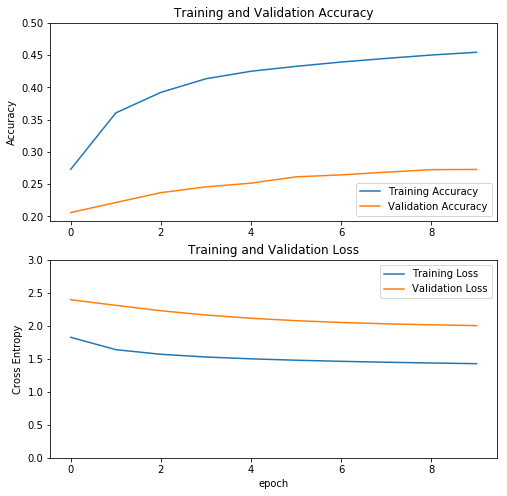

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning
In our previous model training, we were only training a few layers on top of a frozen MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

`Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.`

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

#### Unfreeze top layers of the network
All you need to do is unfreeze the base_model and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


#### Compile the model
Compile the model using a much lower training rate.

In [45]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 1,871,559
Non-trainable params: 395,392
_________________________________________________________________


In [47]:
len(model.trainable_variables)

58

#### Continue training the model
If you trained to convergence earlier, this will get you a few percent more accuracy.

In [48]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
898/898 [==============================] - 142s 158ms/step - loss: 1.3566 - accuracy: 0.4849 - val_loss: 1.6778 - val_accuracy: 0.3567
Epoch 12/20
898/898 [==============================] - 115s 128ms/step - loss: 1.1832 - accuracy: 0.5591 - val_loss: 1.6370 - val_accuracy: 0.3698
Epoch 13/20
898/898 [==============================] - 117s 130ms/step - loss: 1.0560 - accuracy: 0.6157 - val_loss: 1.6290 - val_accuracy: 0.3721
Epoch 14/20
898/898 [==============================] - 115s 129ms/step - loss: 0.9500 - accuracy: 0.6671 - val_loss: 1.6258 - val_accuracy: 0.3835
Epoch 15/20
898/898 [==============================] - 116s 129ms/step - loss: 0.8563 - accuracy: 0.7113 - val_loss: 1.6379 - val_accuracy: 0.3838
Epoch 16/20
898/898 [==============================] - 115s 128ms/step - loss: 0.7704 - accuracy: 0.7512 - val_loss: 1.6535 - val_accuracy: 0.3846
Epoch 17/20
898/898 [==============================] - 114s 127ms/step - loss: 0.6903 - accuracy: 0.7877 - val_loss: 1

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss and the validation accuracy is much much lower than the training accuracy so the model is most likely overfitted. We only have a few hundred images per class so this is quite possible.

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

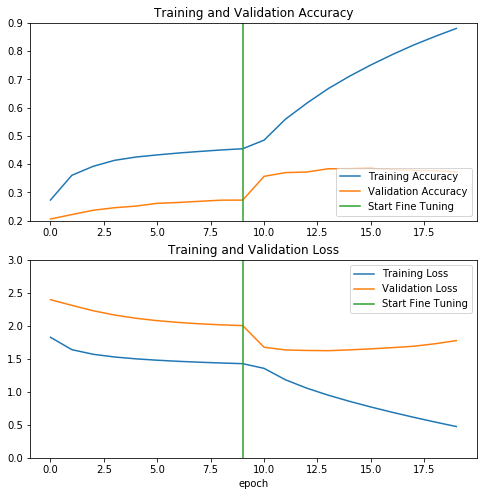

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, .9])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
#model.evaluate(test_batches, steps = validation_steps)
predictions = model.predict(test_batches)
#train_size = int(0.8 * image_count)
#val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)
#print(val_size, len(all_image_labels[train_size:train_size+val_size]))
print(test_size, len(all_image_labels[-test_size:]))
predictions = np.argmax(predictions, axis=1)
len(predictions)

3588 3588


3588

tf.Tensor(
[[227   1   2  43 102 104   2]
 [ 24   1   0   9   6  13   0]
 [190   0  16  48 118 124  17]
 [141   1   9 478 149 118   8]
 [135   0   4  57 276 123   3]
 [168   0   7  54 151 255   2]
 [108   0  10  35 103  45 101]], shape=(7, 7), dtype=int32)


{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

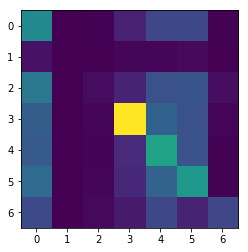

In [111]:
#print(model.evaluate(validation_batches))
#len(all_image_labels[train_size:train_size+val_size])
confusion = tf.math.confusion_matrix(all_image_labels[-test_size:], predictions, num_classes=7)
print(confusion)
plt.imshow(confusion)
label_to_index

#### Trying on a completely different images
Lets see if our model can generalise well to some images from the web.

In [112]:
!sudo unzip -o sample_images.zip
sample_paths = get_image_paths('sample_images', '*')
print(sample_paths)

Archive:  sample_images.zip
  inflating: sample_images/grumpy_cat.jpg  
  inflating: __MACOSX/sample_images/._grumpy_cat.jpg  
  inflating: sample_images/angry_cat.jpg  
  inflating: __MACOSX/sample_images/._angry_cat.jpg  
  inflating: sample_images/monalisa.png  
  inflating: __MACOSX/sample_images/._monalisa.png  
  inflating: sample_images/brando.png  
  inflating: __MACOSX/sample_images/._brando.png  
  inflating: sample_images/jackman.png  
  inflating: __MACOSX/sample_images/._jackman.png  
  inflating: sample_images/pablo.png  
  inflating: __MACOSX/sample_images/._pablo.png  
['sample_images/jackman.png', 'sample_images/monalisa.png', 'sample_images/angry_cat.jpg', 'sample_images/brando.png', 'sample_images/pablo.png', 'sample_images/grumpy_cat.jpg']


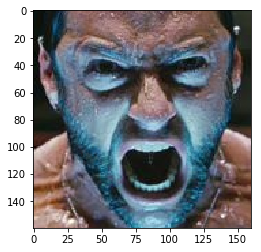

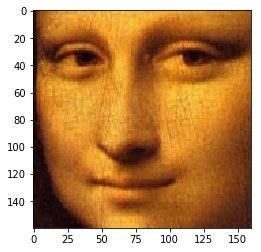

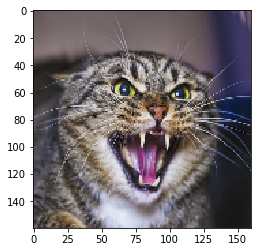

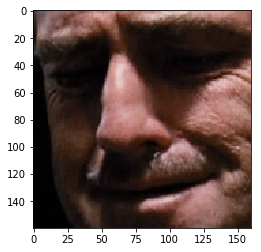

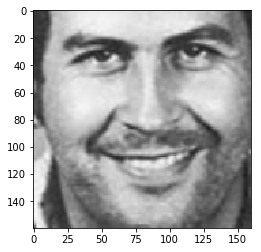

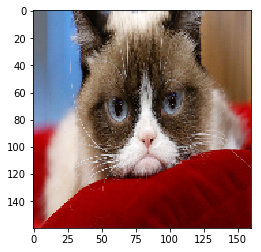

In [113]:
sample_ds = tf.data.Dataset.from_tensor_slices(sample_paths)
sample_ds = sample_ds.map(load_and_preprocess_image)
for sample in sample_ds.take(6):
    plt.figure()
    plt.imshow(sample)

In [114]:
pred = model.predict(sample_ds.batch(6))
pred = np.argmax(pred, axis=1)
print(np.array(label_names)[pred])

['Sad' 'Sad' 'Angry' 'Sad' 'Happy' 'Sad']


#### Saving the models

In [68]:
tf.saved_model.save(model, '')

In [69]:
model.save('emotion.h5')

In [70]:
!tflite_convert --output_file=emotion.tflite --keras_model_file=emotion.h5

2019-07-12 09:31:49.473751: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.0
2019-07-12 09:31:51.564077: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-07-12 09:31:51.567310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-07-12 09:31:51.567700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-07-12 09:31:51.567745: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.0
2019-07-12 09:31:51.569442: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.1

In [71]:
!ls -l

total 118868
drwxr-xr-x 2 jupyter jupyter            4096 Jul 12 09:31 assets
-rw-r--r-- 1 jupyter jupyter        16974624 Jul 12 09:31 emotion.h5
-rw-r--r-- 1 jupyter jupyter          382587 Jul 12 08:09 EmotionModel_backup.ipynb
-rw-r--r-- 1 jupyter jupyter          320359 Jul 12 09:32 EmotionModel.ipynb
-rw-r--r-- 1 jupyter jupyter         8892056 Jul 12 09:32 emotion.tflite
-rw-r--r-- 1 jupyter jupyter        45816785 Jul 10 10:26 fer2013-images.zip
drwxrwxr-x 5 jupyter google-sudoers     4096 Jan  4  2019 images_fer2013
---------- 1 jupyter jupyter        45802990 Jan  4  2019 images.tar.gz
drwxr-xr-x 2 root    root               4096 Jul 12 09:25 MobileNetV2_transfer
-rw-r--r-- 1 jupyter jupyter         3494695 Jul 12 09:31 saved_model.pb
drwxr-xr-x 7 jupyter jupyter            4096 Jul  8 02:39 tutorials
drwxr-xr-x 2 jupyter jupyter            4096 Jul 12 09:31 variables


## Summary
* Using a pre-trained model for extracting embeddings: When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

* Overfitting can happen when the dataset is small

* But the model appears to be able to generalise its learnings to cat emotions so **YAY!!!**

* Keras model can be saved to various formats and converted to a tflite model for use on devices. Hopefully support for quantisation aware training with TF 2.0 will come soon so we can run the model in a TPU! At the moment it is available for TF 1.13.

## Challenge
Now that you have an understanding of transfer learning, are you able to design a better model architechture on top of MobileNet V2 to recognise emotions better than this current one?